# Dedup Overheads Observation

[0.166015625, 0.1650390625, 0.169921875, 0.1708984375]
[0.02314453125, 0.02919921875, 0.038671875, 0.05703125]
[0.02626953125, 0.01083984375, 0.008380888671875, 0.00729751953125]
[0.019921875, 0.008683203125, 0.007102011718750001, 0.00624751953125]
[0.1484375, 0.13671875, 0.140625, 0.1357421875]
[0.169921875, 0.1552734375, 0.1640625, 0.162109375]
[0.04794921875, 0.05888671875, 0.0876953125, 0.03701171875]
[0.005845068359375, 0.0054655078125, 0.00527763671875, 0.006654736328125]
[0.005118369140625, 0.004780771484375, 0.004613876953125, 0.00581931640625]
[0.140625, 0.1435546875, 0.1318359375, 0.1396484375]
[0.970703125, 1.0068359375, 1.0673828125, 0.94921875]
[0.3681640625, 0.3876953125, 0.5029296875, 0.58984375]
[0.388671875, 0.3818359375, 0.4697265625, 0.5517578125]
[0.2568359375, 0.24609375, 0.265625, 0.31640625]
[0.984375, 1.015625, 1.0087890625, 0.9453125]
[1.0146484375, 1.0244140625, 0.99609375, 1.0146484375]
[0.3525390625, 0.35546875, 0.5537109375, 0.2744140625]
[0.3857421875, 0.2

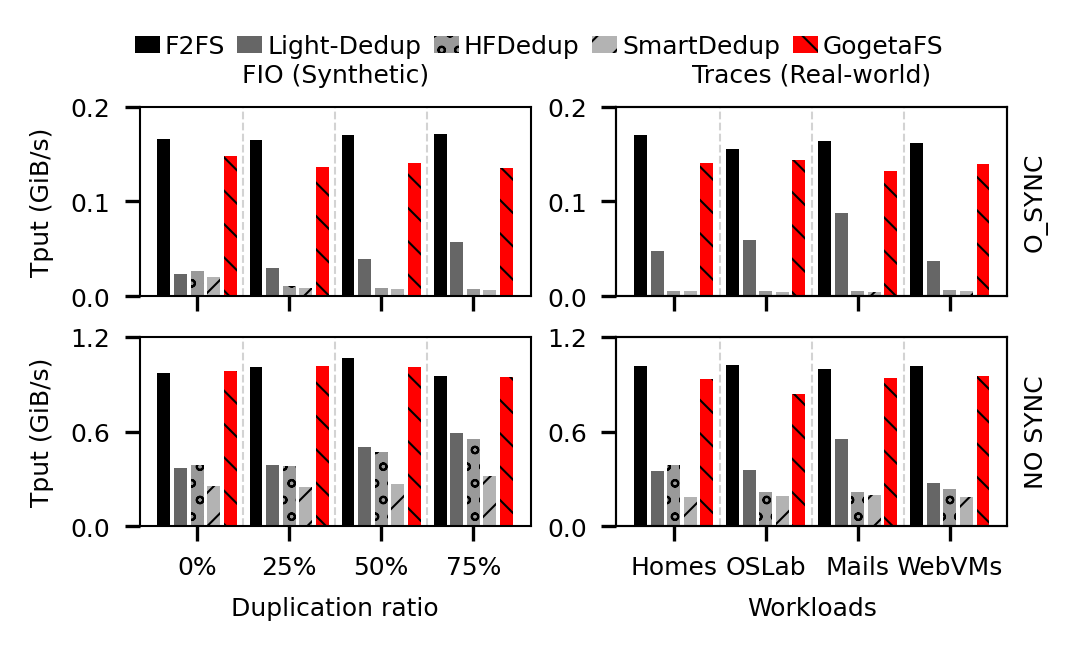

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
# matplotlib style settings
plt.rcParams.update(plt.rcParamsDefault)
matplotlib.rcParams['text.usetex'] = False
%matplotlib inline
style.use('grayscale')
plt.rcParams["axes.grid"] = False
plt.rcParams["axes.grid.axis"] = "both"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["grid.color"] = "lightgray"
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["hatch.color"] = "black"
pd.options.display.max_columns = None
pd.options.display.max_rows = None

# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
with open("./performance-comparison-table", "r") as f:
    df_fio = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("./performance-comparison-table-no-sync", "r") as f:
    df_fio_no_sync = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("../FIG_RealWorld/performance-comparison-table", "r") as f:
    df_real = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')
with open("../FIG_RealWorld/performance-comparison-table-no-sync", "r") as f:
    df_real_no_sync = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

sort_dict = {
    "f2fs-main": 3, 
    "GogetaFS-smartdedup": 1,
    "GogetaFS-hfdedup": 2,
    "GogetaFS-main": 0,
}

sort_df = pd.DataFrame(df_fio['file_system'].map(sort_dict))
# sort_df["num_job"] = df_fio['num_job']
df_fio = df_fio.iloc[sort_df.sort_values(by = ["file_system"]).index]


# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(SINGLE_COL_WIDTH), cm_to_inch(5)))
fig.patch.set_facecolor('white')

bar_width = 0.18
true_bar_width = 0.14
num_job = 1

patterns = ['/', '', 'ooo', "///", "\\\\\\", "xxx"]

ylims = [
    [0, 0.2],
    [0, 0.2],
    [0, 1.2],
    [0, 1.2],
]


breakdown_times = [["fp_time", "cmp_time"], ["table_time", "index_time"], ["io_time"], ["fs_time"]]

blks = [1]
blks_fio = ['4K']

bars = []
global_color_idx = 0
color_map = {}
# grayscale colors
colors = ["black", "dimgray", "lightgray", "gainsboro", "whitesmoke"]
for df_idx, df in enumerate([df_fio, df_real, df_fio_no_sync, df_real_no_sync]):
    for blk_idx, blk in enumerate(blks):
        if df is df_fio or df is df_fio_no_sync:
            real_bs = blks_fio[blk_idx]
            workload_map = {
                0: [],
                25: [],
                50: [],
                75: [],
            }
            workload_kw = "dup_rate"
            workloads = [ 0, 25, 50, 75 ]
            workloads_rename = ["0%", "25%", "50%", "75%"]
        else:
            real_bs = blk * 4096
            workload_map = {
                "homes": [],
                "os": [],
                "mail": [],
                "web": [],
            }
            workload_kw = "workload"
            workloads = [ "homes", "os", "mail", "web" ]
            workloads_rename = ["Homes", "OSLab", "Mails", "WebVMs"]
            # workloads = ["write", "webproxy.f"]
            # workloads_remap = ["SW", "WPX"]

            # workloads.reverse()
            # workloads_rename.reverse()
            
        fss = pd.Series(["f2fs-main", "GogetaFS-lightdedup", "GogetaFS-hfdedup", "GogetaFS-smartdedup", "GogetaFS-main"])
        
        x = list(range(1, len(workloads) + 1))

        tot = len(fss) * bar_width
        fid = df_idx * len(blks) + blk_idx
        subfig = plt.subplot(2, 2, fid + 1) 
        # ax2 = subfig.twinx()
        pivots = []

        for idx, fs in enumerate(fss):
            bws = []
            points = []
            for pivot in range(len(workloads)):
                point = pivot - tot / 2 + bar_width / 2 + idx * bar_width
                points.append(point)
            for workload_id, workload in enumerate(workloads):
                
                if df is df_fio or df is df_fio_no_sync:
                    bws.append(df[(df['file_system'] == fs) & (df['dup_rate'] == workload)]["bandwidth(MiB/s)"].iloc[0] / 1024)
                else:
                    bws.append(df[(df['file_system'] == fs) & (df['trace'] == workload)]["bandwidth(MiB/s)"].iloc[0] / 1024)
                        
            print(bws)
            if fs == "GogetaFS-main":
                bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5, color="red")
            else:
                bar = plt.bar(points, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5)
            # bar, = plt.plot(reg_pts, bws, width=true_bar_width, hatch=patterns[idx], linewidth=0.5)
            
            bars.append(bar)
            if fs == "GogetaFS-main":
                # add vline to each bar
                for point in points[:-1]:
                    plt.axvline(x=point + true_bar_width, color='lightgray', linewidth=0.5, linestyle='--')
        
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        
        if fid == 2 or fid == 3:
            plt.xticks(range(len(workloads)), labels=workloads_rename, fontsize=6)
            plt.xlabel("Duplication ratio" if fid == 2 else "Workloads", fontsize=6)
        else:
            plt.xticks(range(len(workloads)), labels=[], fontsize=6)
        # plt.xticks(blks_pts, labels=[], fontsize=6)
        if fid == 0 or fid == 1:
            subfig.set_title("FIO (Synthetic)" if fid == 0 else "Traces (Real-world)", fontsize=6)
        if (fid == 0 or fid == 2):
            plt.ylabel('Tput (GiB/s)', fontsize=6)

        
        
        subfig.tick_params(bottom=False, top=False, left=False, right=False, which='minor')
        
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
        plt.ylim(ylims[fid])
        yticks = np.linspace(ylims[fid][0], ylims[fid][1], 3)
        if (ylims[fid][0] != 0):
            ax.get_yticklabels()[0].set_color("red")
        plt.yticks(yticks, fontsize=6)
        
        if (fid == 1 or fid == 3):
            ax2 = ax.twinx()
            ax2.set_ylabel("O_SYNC" if fid == 1 else "NO SYNC", fontsize=6)
            ax2.set_yticks([])
            ax2.set_yticklabels([])
            for axis in ['top','bottom','left','right']:
                ax2.spines[axis].set_linewidth(lw)

print(len(bars))

# legends = ["Dup Identify", "Dedup Metadata", "Data Write", "FS Metadata" ]
fig.legend(bars, fss.map({
        "f2fs-main": "F2FS", 
        "GogetaFS-hfdedup": "HFDedup",
        "GogetaFS-lightdedup": "Light-Dedup",
        "GogetaFS-smartdedup": "SmartDedup",
        "GogetaFS-main": "GogetaFS",
        "GogetaFS-no-prefetch": "GogetaFS-no-prefetch",
    }), loc='upper center', ncol=6, bbox_to_anchor=(0.5, 1.05), frameon=False, columnspacing=0.5, handletextpad=0.2, handlelength=1, borderpad=0.2, labelspacing=0.2, fontsize=6)

plt.tight_layout(pad=0.4)
plt.savefig("./FIG-Port.pdf", bbox_inches='tight', pad_inches=0)
